Final Phase 4 Project 

Student name: Mulwa Joseph
Class: DSPT-08 
Scheduled project review date/time: 12/2/2025
Instructor name: Daniel Ekale

### Project Overview

We will use MovieLens dataset (see https://grouplens.org/datasets/movielens/) for finding similar users
based on common movies the users have watched and how they have rated those movies. 
We will be using collaborative filterin to find similarity between users

### Objectives

 1. Retrieve the top 5 movie title recommended to user based on their ratings
 2. Enable users explore a wide range of films similar to their preferences 
 3. Drive users subscriptions by suggesting appealing content

### Libraries

In [154]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
import re
from fuzzywuzzy import process
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from surprise.model_selection import cross_validate


from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline

### Loading Dataset 

In [155]:
#Loading dataset
movies = pd.read_csv("ml-latest-small/ml-latest-small/movies.csv")
ratings =  pd.read_csv("ml-latest-small/ml-latest-small/ratings.csv")

In [156]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [157]:
#Dropping timestamp from our dataframe
ratings.drop('timestamp', axis = 1, inplace =True)

In [158]:
#number of unique mivies in the dataset
len(ratings.movieId.unique())

9724

In [159]:
#Merge the datasets together
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### EDA

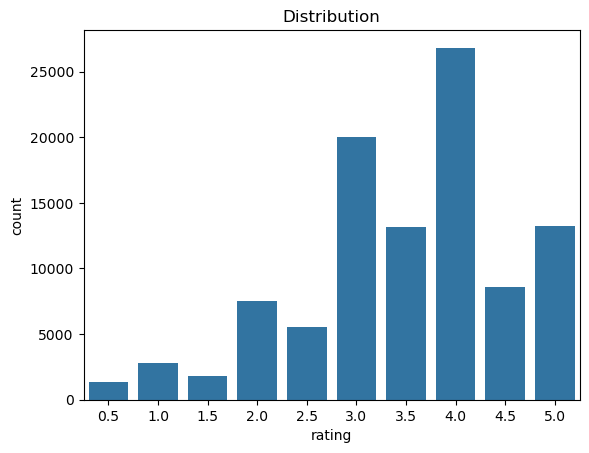

In [160]:
sns.countplot(x='rating',data=ratings)
plt.title('Distribution')
plt.show()

In [161]:
#The top 5 rated movies
movie_ratings = ratings.merge(movies, on='movieId')
top_movies = movie_ratings['title'].value_counts().nlargest(5)
print(top_movies)

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: count, dtype: int64


In [162]:
#Split the genres to a list
movies['genres'] =  movies['genres'].apply(lambda x: x.split ('|'))

total_genre = Counter(g for genres in movies ['genres'] for g in genres)

print(f'No of genres{len(total_genre)}')

No of genres20


In [ ]:
#Top 10 genre visualization
#Change  to dataframe 
top_genre_df = pd.DataFrame([total_genre]).T.reset_index()
top_genre_df.columns = ['genre','count']
plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='count', data=top_genre_df, palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top 10 Most Common Movie Genres")
plt.xticks(rotation=45)  
plt.show()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_7608\2386159201.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=top_genre_df, palette="viridis")


### Data Processing

In [ ]:
#Replacing the NAN values in our dataframe
movies_df.fillna(0, inplace = True)
movies_df.iloc[0:5, 0:10]

movieId,1,2,3,4,5,6,7,8,9,10
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# #Creating a pivot table to represent users as rows and movies as columns
movies_df = movie_ratings.pivot(index ='userId',columns='movieId',values = 'rating')
movies_df.index = movie_ratings.userId.unique()

In [ ]:
#Representing the similarity between rows and converting them in a dataframe
#similarity closer to 1 means users are very similar and closer to 0 means users are very dissimilar.
row_similarities = 1 - pairwise_distances(movies_df.values,metric ="cosine")
row_similarities_df =pd.DataFrame(row_similarities)
row_similarities_df.index = movie_ratings.userId.unique()
row_similarities_df.columns = movie_ratings.userId.unique()

row_similarities_df.iloc[0:5, 0:5]

ValueError: Input contains NaN.

In [ ]:
#To find silmilar users
np.fill_diagonal(row_similarities, -1)
similar_users = row_similarities_df.idxmax(axis=1)
print(similar_users[0:5])

1    266
2    366
3    313
4    391
5    470
dtype: int64


In [ ]:
#To get movies rated greater than 4
high_rated_movies = movie_ratings[movie_ratings['rating'] >4]
high_rated_movies


,userId,movieId,rating,title,genres
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
6,1,101,5.0,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
8,1,151,5.0,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,Canadian Bacon (1995),Comedy|War
...,...,...,...,...,...
100821,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100829,610,164179,5.0,Arrival (2016),Sci-Fi
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror


#Creating the Cosine similarity between movies

In [ ]:

user_item_matrix = movie_ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.fillna(0)
item_item_matrix = user_item_matrix.T

movies_sim = cosine_similarity(item_item_matrix)
movies_sim_df = pd.DataFrame(movies_sim, index=item_item_matrix.index, columns=item_item_matrix.index)
def get_similar_movies(movie_id, top_n=5):
    if movie_id not in movies_sim_df.index:
        return f"Movie ID {movie_id} not found in the dataset."
    sim_score = movies_sim_df.loc[movie_id]
    sim_movies = sim_score.sort_values(ascending=False)
    similar_movie_ids = sim_movies.drop(movie_id).head(top_n).index
    
    similar_movies_details = movie_ratings[movie_ratings['movieId'].isin(similar_movie_ids)][['movieId', 'title', 'genres']].drop_duplicates()
    
    return similar_movies_details

movie_id = 344  
similar_movies = get_similar_movies(movie_id, top_n=3)


print(f"Top 3 similar movies to movieId {movie_id}:")
print(similar_movies)

Top 3 similar movies to movieId 344:
     movieId                                   title  \
13       231  Dumb & Dumber (Dumb and Dumber) (1994)   
525      153                   Batman Forever (1995)   
626      165       Die Hard: With a Vengeance (1995)   

                            genres  
13                Adventure|Comedy  
525  Action|Adventure|Comedy|Crime  
626          Action|Crime|Thriller  


####Using Suprise 

In [ ]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(movie_ratings[['userId','movieId','rating']],reader=reader)

In [ ]:
#KNN Model
item_based_sim = {'name':'pearson',
                  'user_based':True}
knn = KNNBasic(k=20,
             min_k = 5,
             sim_options = item_based_sim)

In [ ]:
#5-fold Validation to measure RMSE
cv = cross_validate(knn,
                    data,
                    measures = ['RMSE'],
                    cv =5,
                    verbose =False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
knn_rmse = cv['test_rmse'].mean()
knn_rmse

0.9708057553153184

In [ ]:
#  the SVD model,with cross validation
svd = SVD()
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=False)
svd_rmse = svd_cv['test_rmse'].mean()
print(f"SVD Model RMSE: {svd_rmse:.4f}")

SVD Model RMSE: 0.8735


In [ ]:
#comparing KNN and SVD to determine whch has better performance
if knn_rmse < svd_rmse:
    print("KNN performs better than SVD.")
else:
    print("SVD performs better than KNN.")

SVD performs better than KNN.


## Recommender System

In [ ]:
#splitting dataset
train_set,test_set = train_test_split(data, test_size =0.2, random_state=42)

In [ ]:
#Grid search on SVD for better performance
#Hyperparameter Tuning for SVD
param_grid = {
    'n_factors': [50, 100, 200],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.06]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'MAE'], cv=5)
grid_search.fit(data)
print(grid_search.best_score['rmse'])
print(grid_search.best_params['rmse'])

0.8585886589185432
{'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.06}


In [ ]:
#Using SVD for collaborative filtering for model trainin
best_svd = grid_search.best_estimator['rmse']
trainset = data.build_full_trainset()
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(trainset)

In [ ]:
predictions = svd_model.test(test_set)
svd_rmse = accuracy.rmse(predictions)
print(f"SVD RMSE: {svd_rmse}")

RMSE: 0.7215
SVD RMSE: 0.7215343631322634


In [ ]:
# #Allowing partial matches
# def get_similar_movies_fuzzy(movie_title, top_n=5):
#     movie_title = movie_title.strip().lower()
#     best_match, score = process.extractOne(movie_title, movies_sim_df.index, score_cutoff=80)
#     if best_match:
#         print(f"Best match: '{best_match}' (confidence: {score})")
#         sim_scores = movies_sim_df.loc[best_match]
#         sorted_scores = sim_scores.sort_values(ascending=False)[1:top_n+1]
#         return sorted_scores
#     else:
#         print(f"No close match found for '{movie_title}' in the dataset.")
#         return None

In [ ]:
# Create a mapping between movie titles and movie IDs
movie_title_to_id = dict(zip(movie_ratings['title'], movie_ratings['movieId']))
movie_id_to_title = dict(zip(movie_ratings['movieId'], movie_ratings['title']))

# Function to handle user input and get similar movies
def recommend_movies(user_input, top_n=5):
    if user_input.isdigit():
        movie_id = int(user_input)
        if movie_id not in movie_id_to_title:
            return f"Movie ID {movie_id} not found in the dataset."
    else:
        if user_input not in movie_title_to_id:
            return f"Movie title '{user_input}' not found in the dataset."
        movie_id = movie_title_to_id[user_input]
    
    similar_movies = get_similar_movies(movie_id, top_n)
    return similar_movies

# Example usage
user_input = input("Enter a movie title or movie ID: ")
similar_movies = recommend_movies(user_input, top_n=5)

print(f"Top 5 similar movies to '{movie_id_to_title[int(user_input)] if user_input.isdigit() else user_input}':")
print(similar_movies)


Top 5 similar movies to 'Bliss (1997)':
       movieId                                            title        genres
13092       55                                   Georgia (1995)         Drama
13146      324                            Sum of Us, The (1994)  Comedy|Drama
13166      406                              Federal Hill (1994)         Drama
13212      722  Haunted World of Edward D. Wood Jr., The (1996)   Documentary
13213      726                                Last Dance (1996)         Drama


In [ ]:
print(movies_sim_df.index)

Index([     1,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585, 193587,
       193609],
      dtype='int64', name='movieId', length=9724)


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
